# `XGBoost` ML training for Cosmic Ray Veto optimisation

## Objective
Optimize the veto condition to maximize cosmic ray purity while minimizing pileup contamination.

**Run tag:** `a`

## Preprocessing
- Execution: `run/run_ml_prep.py`
- Core logic: `src/core/ml_process.py`

## Training datasets

### Mixed CE (background - label 0)
- `nts.mu2e.CeEndpointMix2BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root`

### Pure CRY (signal - label 1)
- `nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`

## Training strategy

Discriminate between:
1. Coincidences from **mixed CE**
2. Coincidences from **pure CRY**

## Implementation 
Discriminate between:
1. Coincidences from **mixed CE**
2. Coincidences from **mixed CRY** (cosmic-produced only, identified via MC truth)

In [1]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../../src/core", "../../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [6]:
!ls ../../../output/ml/veto/a/data
!ls -ltrh ../../../output/ml/veto/a/data/CRY_onspill-LH_aw
# !ls ../../output/ml/cosmic/data/sig/b/results.pkl
# ! ls ../output/ml/data/b/bkg/

CRY_mix2BB_onspill-LH_aw       CRY_onspill-LH_aw       sig_mix_onspill-LH_aw
CRY_mix2BB_onspill-LH_aw_test  CRY_onspill-LH_aw_test  sig_onspill-LH_aw
total 19M
-rw-r--r-- 1 sam sam  12M Nov 11 09:21 results.pkl
-rw-r--r-- 1 sam sam  906 Nov 11 09:21 cut_flow.csv
-rw-r--r-- 1 sam sam 224K Nov 11 09:21 hists.h5
-rw-r--r-- 1 sam sam 7.3M Nov 11 09:21 events.parquet


In [9]:
run = "a"
base_in_path = Path(f"../../../output/ml/veto/{run}/data/")
cry_in_path = base_in_path / "CRY_onspill-LH_aw"
sig_mix_in_path = base_in_path/ "sig_mix_onspill-LH_aw"

cry_data = Load(in_path=cry_in_path).load_pkl()
sig_mix_data = Load(in_path=sig_mix_in_path).load_pkl()

[Load] ✅ Initialised with out_path=../../../output/ml/veto/a/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/a/data/CRY_onspill-LH_aw/results.pkl
[Load] ✅ Initialised with out_path=../../../output/ml/veto/a/data/sig_mix_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/a/data/sig_mix_onspill-LH_aw/results.pkl


## Verify data

In [10]:
display(cry_data["cut_flow"])
display(sig_mix_data["cut_flow"])

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2610933,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2558235,97.982,97.982,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,2558229,97.981,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,2478081,94.912,96.867,Electron track fits
4,one_reco_electron,Preselect,2050975,78.553,82.765,One reco electron / event
5,is_downstream,Preselect,1127230,43.173,54.961,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,Preselect,320790,12.286,28.458,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,253943,9.726,79.162,Track fit quality > 0.2
8,within_t0,Tracker,203324,7.787,80.067,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,188703,7.227,92.809,Track fit t0 uncertainty (t0err < 0.9 ns)


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,1339362,100.000,100.000,No selection applied
1,has_trk_front,Preselect,1336979,99.822,99.822,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,1336978,99.822,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,1327517,99.116,99.292,Electron track fits
4,one_reco_electron,Preselect,1097128,81.914,82.645,One reco electron / event
5,is_downstream,Preselect,1096128,81.840,99.909,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,Preselect,1096059,81.834,99.994,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,883133,65.937,80.573,Track fit quality > 0.2
8,within_t0,Tracker,655446,48.937,74.218,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,636329,47.510,97.083,Track fit t0 uncertainty (t0err < 0.9 ns)


[pyplot] ✅ Wrote:
	h1_abs_dT.png


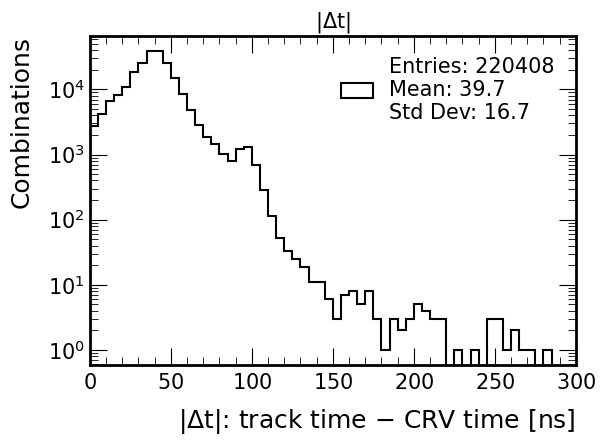

In [11]:
plotter.plot_1D( 
    ak.flatten(abs(cry_data["events"]["dT"]), axis=None),
    nbins=60,
    xmin=0, 
    xmax=300,
    title=r"|$\Delta t$|",
    xlabel=r"|$\Delta t$|: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=True,
    col="black",
    log_y=True,
    out_path=f"h1_abs_dT.png"
)

[pyplot] ✅ Wrote:
	h1_abs_dT.png


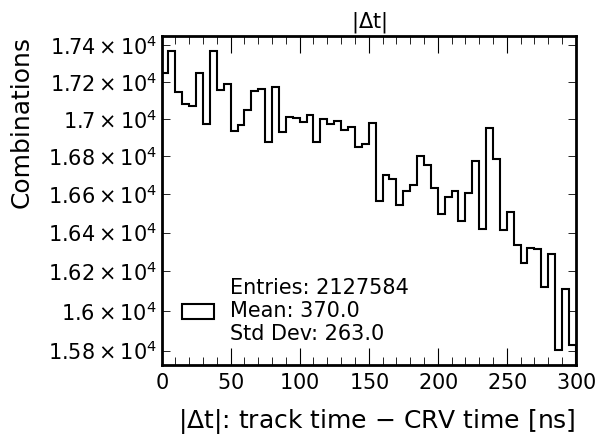

In [6]:
plotter.plot_1D( 
    ak.flatten(abs(sig_mix_data["events"]["dT"]), axis=None),
    nbins=60,
    xmin=0, 
    xmax=300,
    title=r"|$\Delta t$|",
    xlabel=r"|$\Delta t$|: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=True,
    col="black",
    log_y=True,
    out_path=f"h1_abs_dT.png"
)

In [13]:
# help(draw.plot_ml_summary)

[Load] ✅ Initialised with out_path=test_out
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Plot] ⭐️ Initialised
CRY
[Plot] ✅ 	Wrote ../../../output/images/ml/veto/a/xgboost/preparation/h1o_3x3_cuts_CRY.png


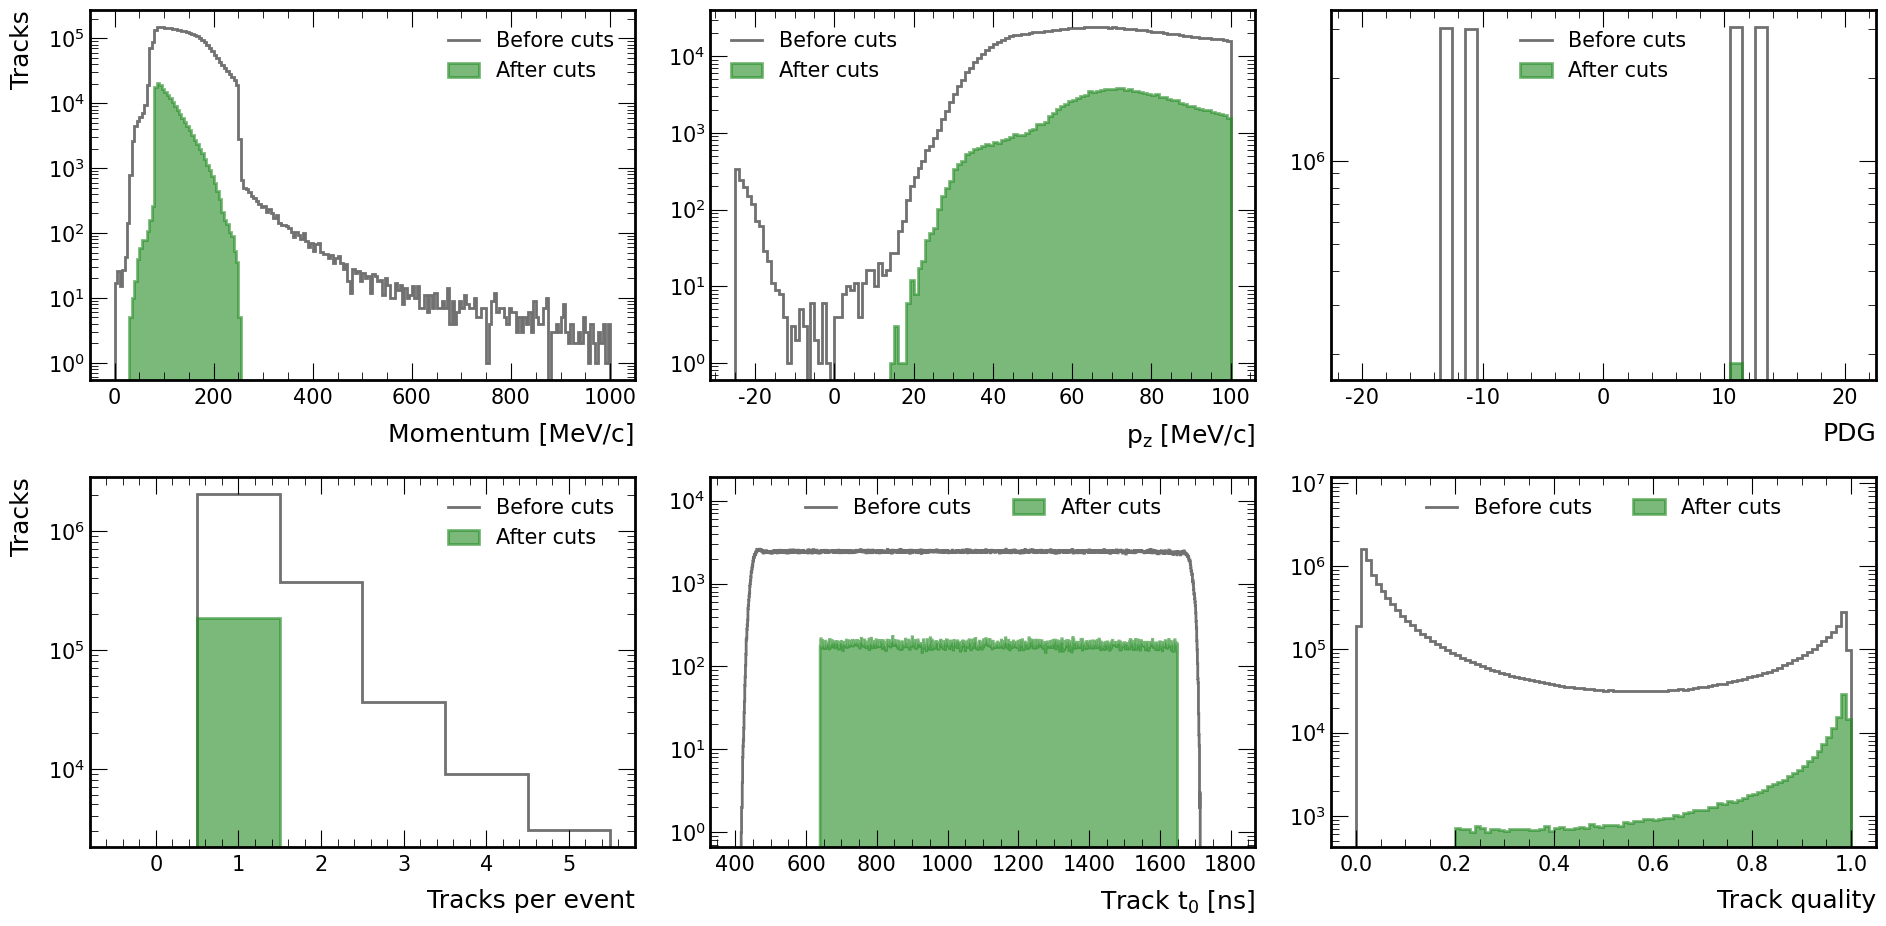

SIGNAL + PILEUP
[Plot] ✅ 	Wrote ../../../output/images/ml/veto/a/xgboost/preparation/h1o_3x3_cuts_CE_mix.png


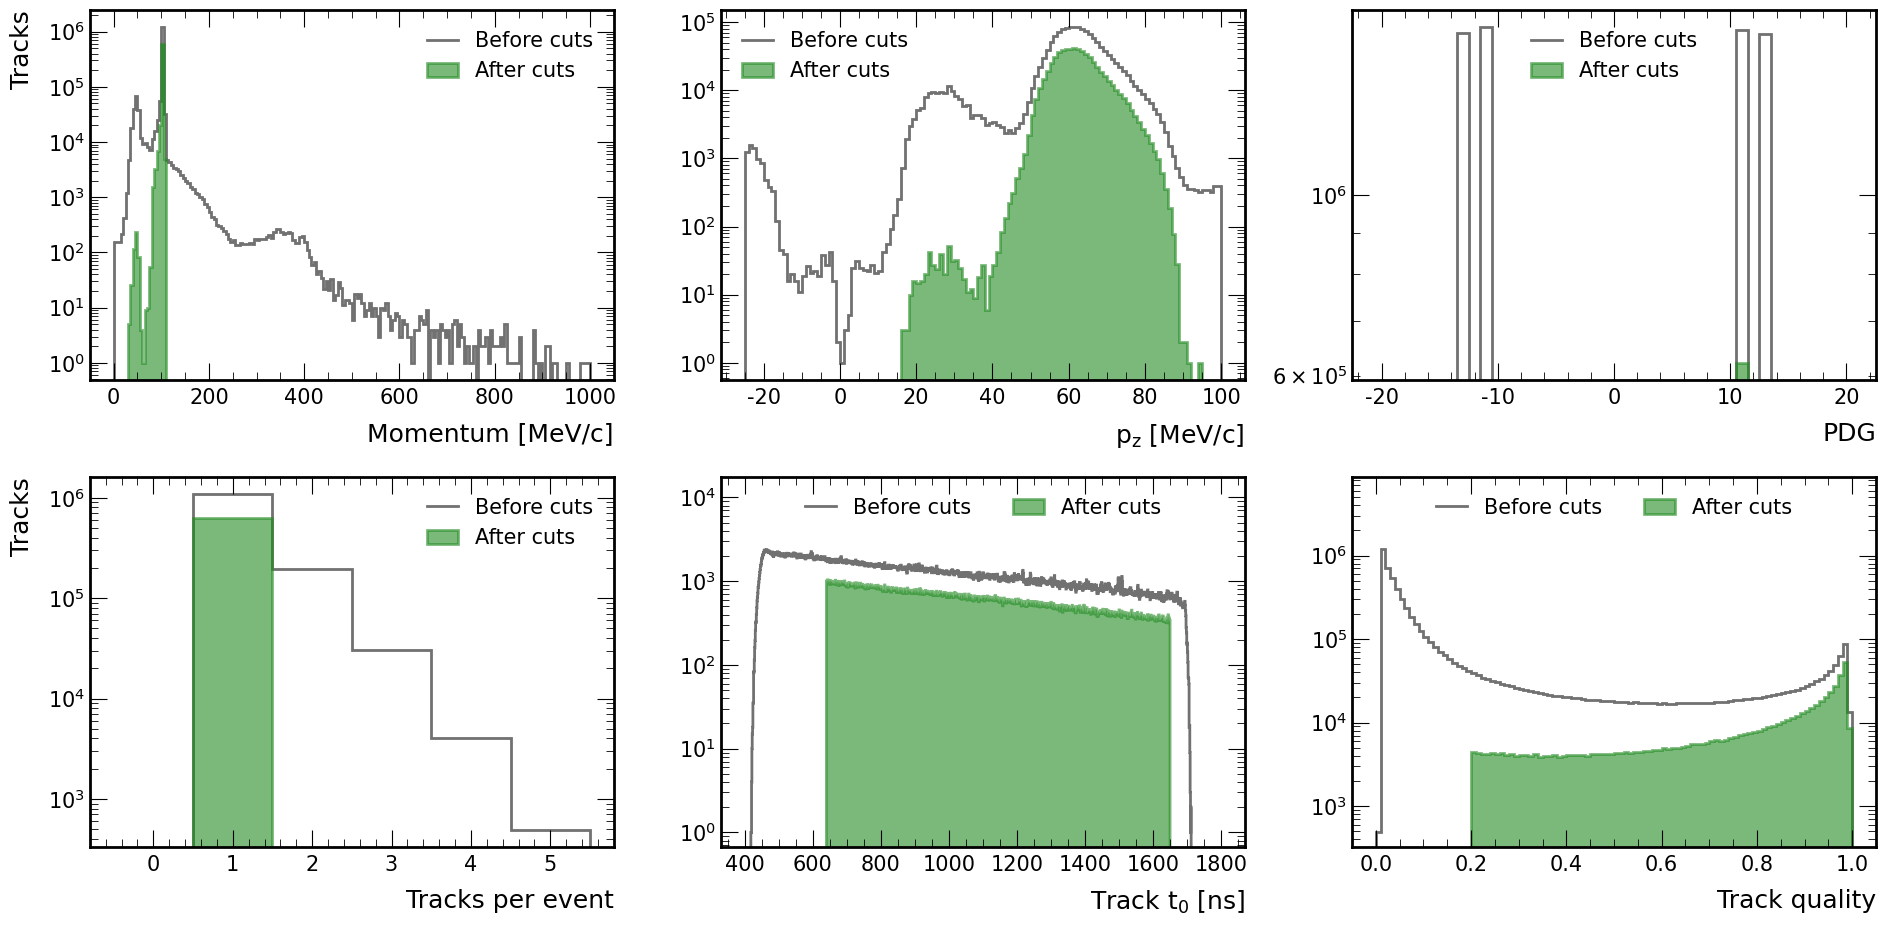

In [14]:
draw = Draw()

img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_feature_out_path = img_base_path / "preparation"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x2_features.png"

print("CRY")
draw.plot_ml_summary(cry_data["hists"], out_path = img_feature_out_path / "h1o_3x3_cuts_CRY.png")

print("SIGNAL + PILEUP")
draw.plot_ml_summary(sig_mix_data["hists"], out_path = img_feature_out_path / "h1o_3x3_cuts_CE_mix.png")

In [15]:
print(cry_data["events"].type)
print(sig_mix_data["events"].type)

220408 * {event: float64, subrun: float64, crv_z: float32, crv_PEs: float32, dT: float64, t0: float64, d0: float32, tanDip: float32, maxr: float32}
2127584 * {event: float64, subrun: float64, crv_z: float32, crv_PEs: float32, dT: float64, t0: float64, d0: float32, tanDip: float32, maxr: float32}


In [16]:
from pyutils.pyprint import Print
Print().print_n_events(sig_mix_data["events"], 10)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 10 event(s)...

-------------------------------------------------------------------------------------
event: 5.0
subrun: 1.0
crv_z: -6851.43505859375
crv_PEs: 101.87531280517578
dT: 432.90195292879685
t0: 1238.5234128897343
d0: 80.76409912109375
tanDip: 0.7250504493713379
maxr: 629.8093872070312
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 5.0
subrun: 1.0
crv_z: -3718.328369140625
crv_PEs: 151.86264038085938
dT: 693.6891843741093
t0: 1238.5234128897343
d0: 80.76409912109375
tanDip: 0.7250504493713379
maxr: 629.8093872070312
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 5.0
subrun: 1.0
crv_z: -9957.7998046875
crv_PEs: 961.2582397460

In [17]:
cry_data["events"]["crv_z"].type.show() # , axis=None)

220408 * float32


## Feature plots

In [18]:
# help(plotter.plot_1D_overlay)

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../../output/images/ml/veto/a/xgboost/features/h1o_2x2_features.png


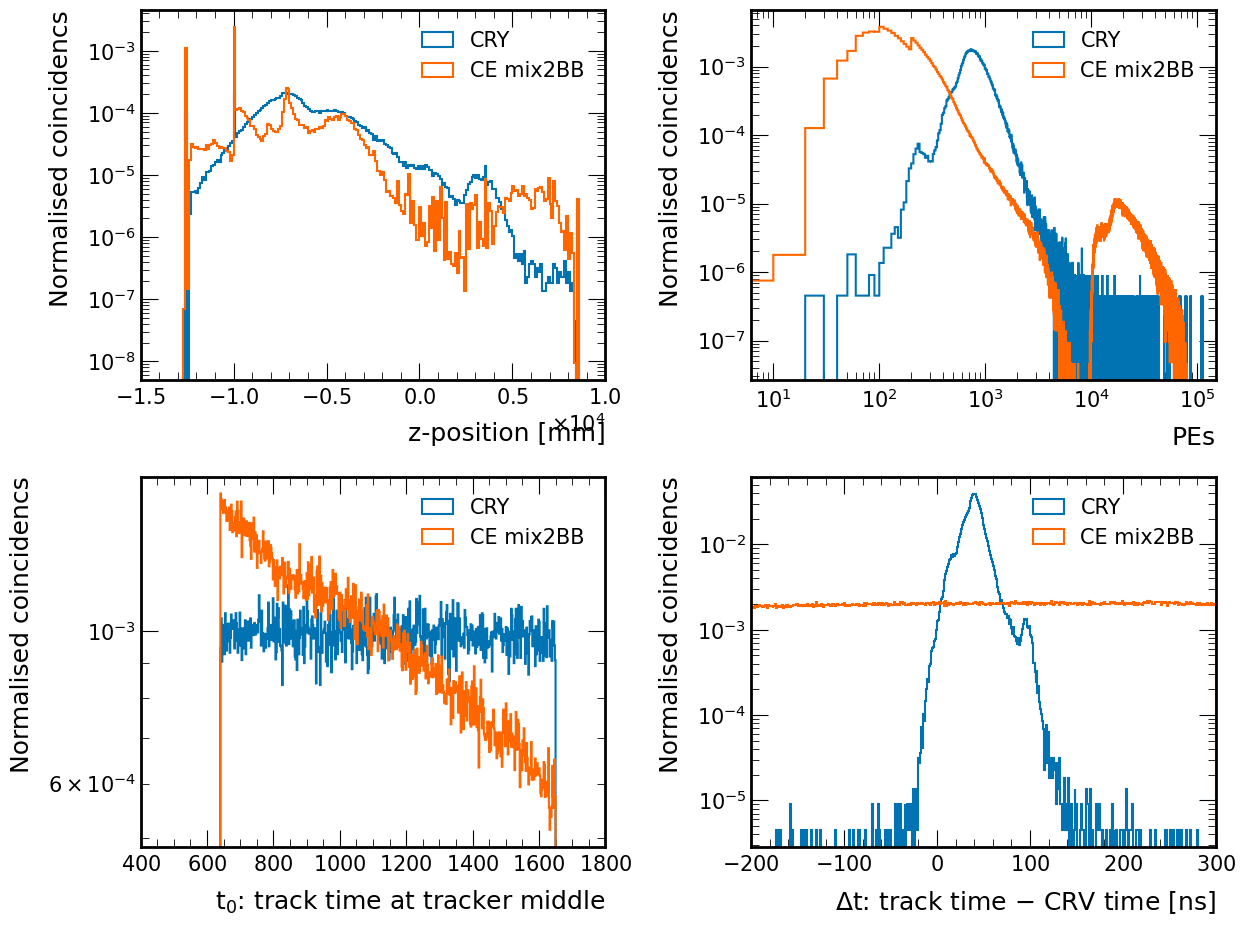

In [19]:
from pyutils.pyplot import Plot 
plotter = Plot()

fig, ax = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))

styles = {

    "CRY" : { 
        "color" : "#0173B2"
    },
    "CE mix2BB" : {
        "color" : "#FF6600"
    }
}
    

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_z"], axis=-1),
        "CE mix2BB": ak.flatten(sig_mix_data["events"]["crv_z"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=250,
    xmin=-15000,
    xmax=10000,
    show=False,
    ax=ax[0,0],
    log_y=True,
    xlabel="z-position [mm]", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_PEs"], axis=-1),
        "CE mix2BB": ak.flatten(sig_mix_data["events"]["crv_PEs"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=int(1.5e4),
    xmin=0,
    xmax=1.5e5,
    show=False,
    ax=ax[0,1],
    log_y=True,
    log_x=True,
    xlabel="PEs", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["t0"], axis=-1),
        "CE mix2BB": ak.flatten(sig_mix_data["events"]["t0"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=700,
    xmin=400,
    xmax=1800,
    show=False,
    ax=ax[1,0],
    log_y=True,
    log_x=False,
    xlabel=r"$t_{0}$: track time at tracker middle", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["dT"], axis=-1),
        "CE mix2BB": ak.flatten(sig_mix_data["events"]["dT"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=int(500),
    xmin=-200,
    xmax=300,
    show=False,
    ax=ax[1,1],
    log_y=True,
    log_x=False,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)


plt.tight_layout()

img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_feature_out_path = img_base_path / "features"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x2_features.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
# plt.show()

In [65]:
# !touch ../../../output/images/ml/veto/hello

	Wrote ../../../output/images/ml/veto/a/xgboost/features/h2o_dT_vs_z.png


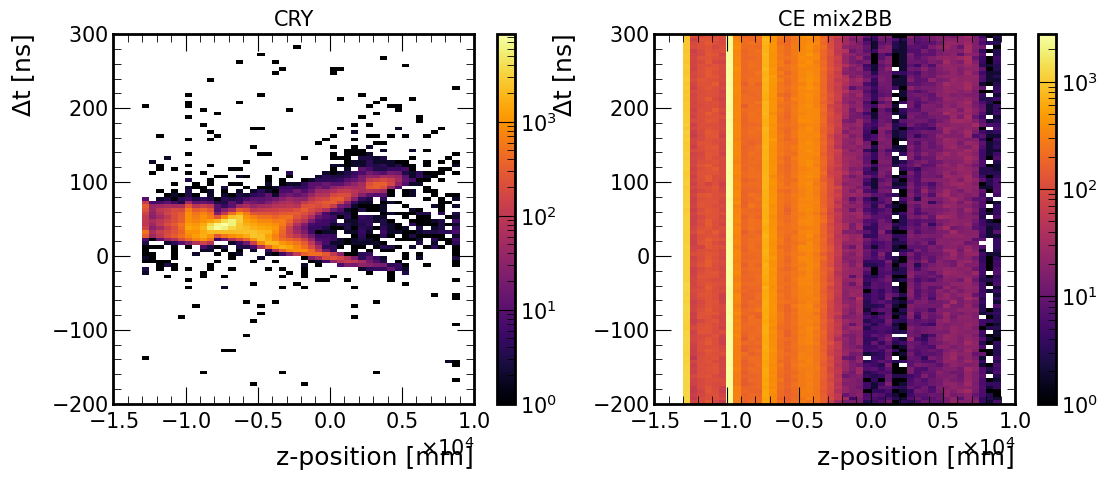

In [21]:
fig, ax = plt.subplots(1,2,figsize=(2*6.4, 4.8))
plotter.plot_2D(
    x = ak.flatten(cry_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(cry_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY",
    ax=ax[0]
)
plotter.plot_2D(
    x = ak.flatten(sig_mix_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(sig_mix_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CE mix2BB",
    ax=ax[1]
)

# img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
# model_out_path = Path(f"../../../output/ml/veto/{run}/models/xgboost/features")
# img_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h2o_dT_vs_z.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
# plt.show()

In [63]:
# !ls ../../../output/images/ml/veto/a/

features  validation  xgboost


## Training 

In [22]:
# Convert to DataFrame
feature_names = ["crv_z", "dT", "t0", "crv_PEs"]

df_CRY = ak.to_dataframe(cry_data["events"])
df_CE_mix = ak.to_dataframe(sig_mix_data["events"])

# drop nactive and t0err
col_to_drop = ["event", "subrun", "d0", "tanDip", "maxr"] 

df_CRY.drop(columns=col_to_drop, axis=1, inplace=True)
df_CE_mix.drop(columns=col_to_drop, axis=1, inplace=True)

df_CRY["label"] = 1 # "signal"
df_CE_mix["label"] = 0 # "background"

In [23]:
# Combine and shuffle
df_train = pd.concat([df_CRY, df_CE_mix], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_train)

,crv_z,crv_PEs,dT,t0,label
0,-3840.117432,346.268372,687.031599,1190.167585,0
1,-9957.799805,474.024323,41.578787,737.658682,0
2,-7853.469727,198.112015,344.612380,1502.560134,0
3,-3152.522705,33.483273,68.499926,1382.765063,0
4,-6301.621582,115.243286,389.772145,1200.588063,0
...,...,...,...,...,...
2347987,-9211.950195,62.151543,124.741868,909.375229,0
2347988,-7509.515625,846.078308,36.875445,997.699175,1
2347989,-4251.872070,75.709579,-577.823756,741.532323,0
2347990,-7249.674805,140.015198,-175.092506,1320.459374,0


In [24]:
X = df_train.drop("label", axis=1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining: {len(X_train)} events")
print(f"Test: {len(X_test)} events")


Training: 1878393 events
Test: 469599 events


In [25]:
# Actually not really needed for BDTs

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


In [26]:
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Assign feature names for plotting / saving
model.get_booster().feature_names = feature_names

print("✅ Training complete!")


🚀 Training XGBoost model...
✅ Training complete!


## Store model

In [27]:
!pwd

/home/sam/mu2e-python/mu2e-cosmic/notebooks/ml/veto


In [28]:
# model_out_path = Path(f"../../../output/ml/veto/models/{run}")
model_out_path = Path(f"../../../output/ml/veto/{run}/models")
model_out_path.mkdir(parents=True, exist_ok=True)


# Full path to model file
model_file_path = model_out_path / "trained_xgboost.json"

# Save the model
model.save_model(str(model_file_path))  # XGBoost often needs string path
print(f"\n✅ Done! Model saved to {model_file_path}")


✅ Done! Model saved to ../../../output/ml/veto/a/models/trained_xgboost.json


## Analyse model 

In [29]:
feature_names

['crv_z', 'dT', 't0', 'crv_PEs']


⭐️ Feature importance:
  crv_z     : 0.4056
  dT        : 0.4377
  t0        : 0.1534
  crv_PEs   : 0.0033
	Wrote ../../../output/images/ml/veto/a/xgboost/validation/bar_feature_importance.png


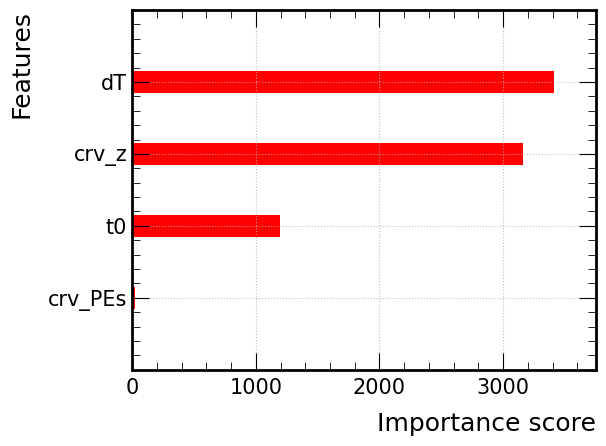

In [30]:
print("\n⭐️ Feature importance:") 
for feat, imp in zip(feature_names, model.feature_importances_):
    print(f"  {feat:10s}: {imp:.4f}") 

xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.3)
plt.title("")
plt.tight_layout()

# img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_validation_out_path = img_base_path / "validation"
img_validation_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_validation_out_path / "bar_feature_importance.png"
plt.savefig(out_name)

print(f"\tWrote {out_name}")
# out_name = img_out_path / "bar_feature_importance.png" 
# plt.savefig(out_name)
plt.show()

In [31]:
train_pred = model.predict_proba(X_train_scaled)[:, 1]
test_pred = model.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)

print(f"\nTraining AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training AUC: 0.9998
Test AUC: 0.9998


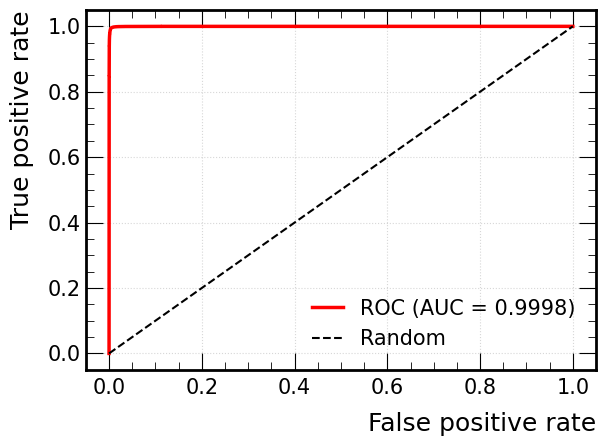


✅ Done! ROC curve saved to ../../../output/images/ml/veto/a/xgboost/validation/roc_curve.png


In [67]:
fpr, tpr, _ = roc_curve(y_test, test_pred)

plt.figure()
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(0.0, 0.2)
# plt.ylim(0.9999, 1)
plt.grid(alpha=0.5)
plt.tight_layout()

out_name = img_validation_out_path /  "roc_curve.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! ROC curve saved to {out_name}")

In [33]:
# Are there duplicate events?
print(f"Train events: {len(X_train)}")
print(f"Test events: {len(X_test)}")
print(f"Overlap: {len(set(X_train.index) & set(X_test.index))}")
print(feature_names)

Train events: 1878393
Test events: 469599
Overlap: 0
['crv_z', 'dT', 't0', 'crv_PEs']


In [34]:
print(img_validation_out_path)

../../../output/images/ml/veto/a/xgboost/validation


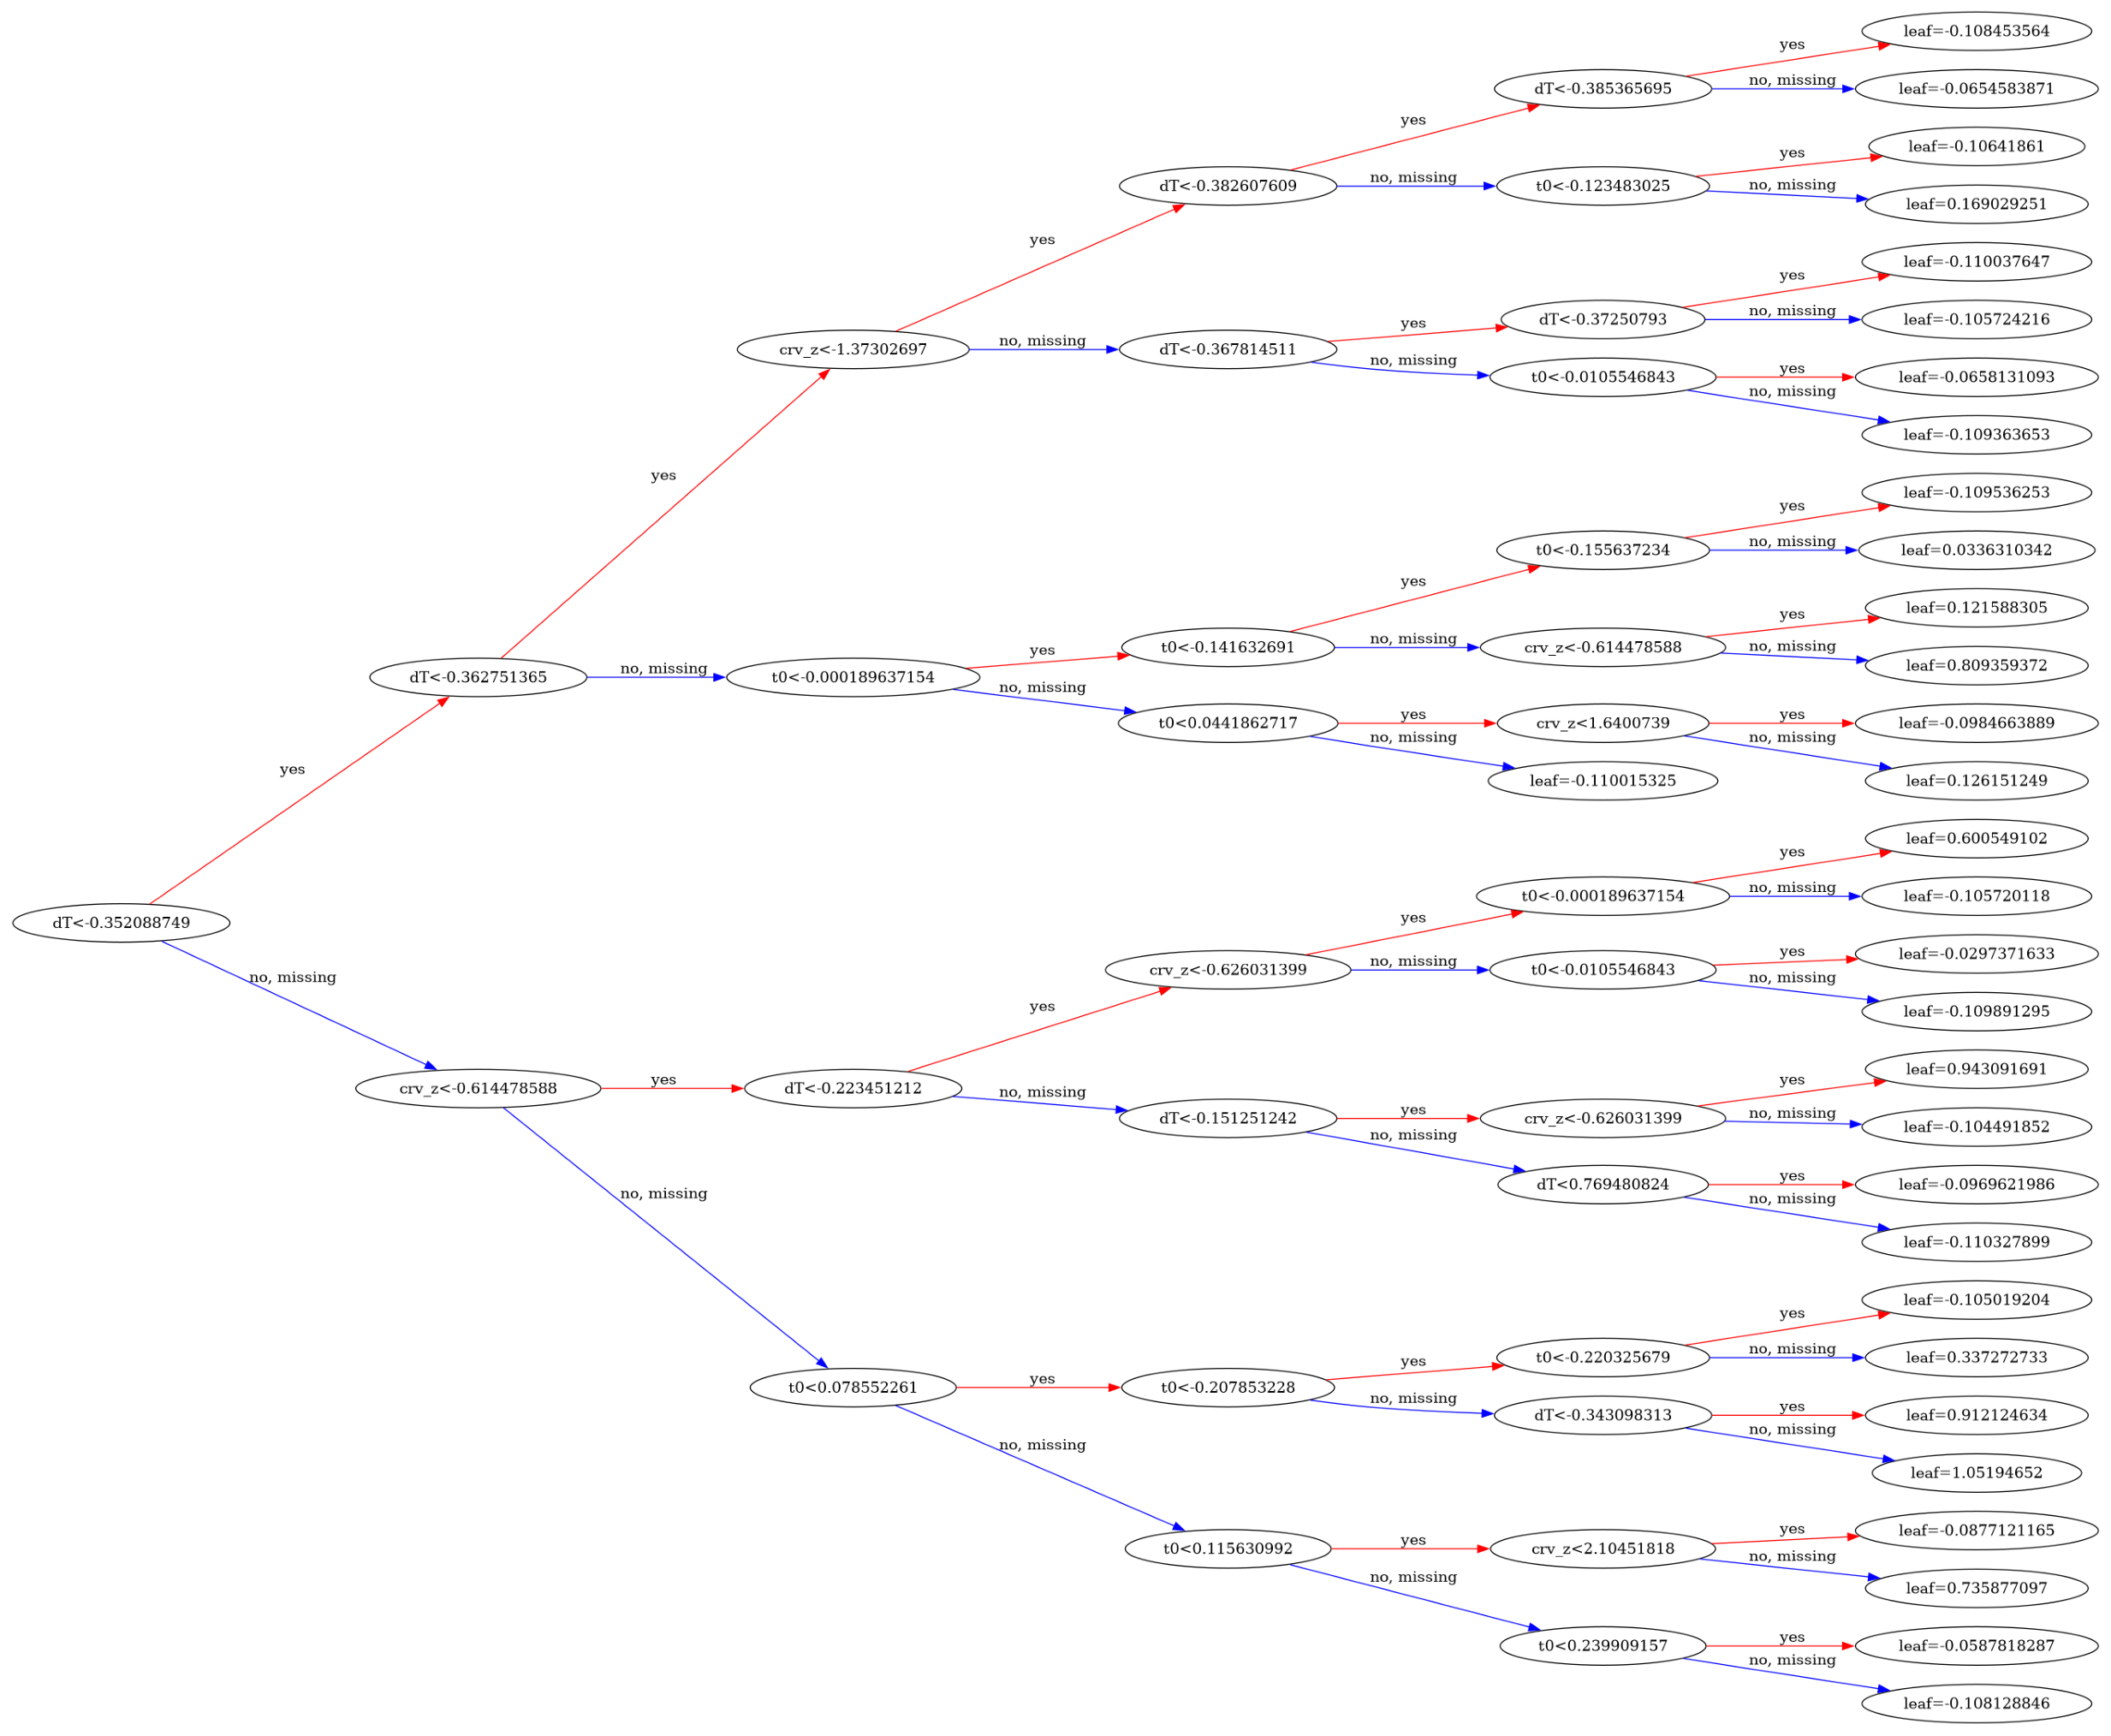


✅ Done! Tree saved to ../../../output/images/ml/veto/a/xgboost/validation/tree_mix.png


In [35]:
fig, ax = plt.subplots(figsize=(25, 25))
xgb.plot_tree(model, num_trees=0, rankdir="LR", ax=ax)
plt.tight_layout()

out_name = img_validation_out_path / "tree_mix.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! Tree saved to {out_name}")

Optimal threshold: 0.495
Maximum significance: 206.3


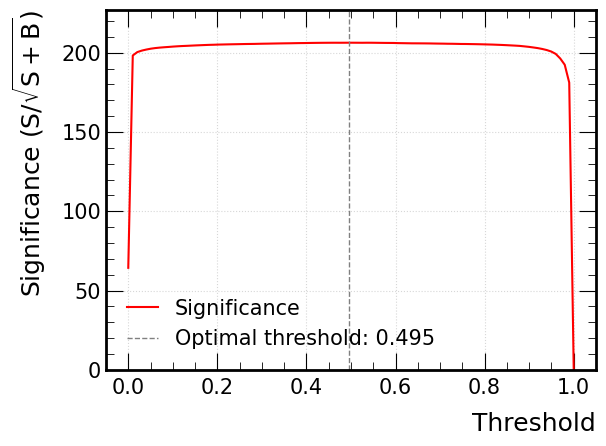


✅ Done! Signal signficance curve saved to ../../../output/images/ml/veto/a/xgboost/validation/sig_sif.png


In [36]:
thresholds = np.linspace(0, 1, 100)
Z_values = []
for thr in thresholds:
    y_pred_label = (test_pred > thr).astype(int)
    S = ((y_test == 1) & (y_pred_label == 1)).sum()
    B = ((y_test == 0) & (y_pred_label == 1)).sum()
    if S+B > 0:
        Z_values.append(S / np.sqrt(S + B))
    else:
        Z_values.append(0)

optimal_idx = np.argmax(Z_values)
optimal_threshold = thresholds[optimal_idx]
max_significance = Z_values[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Maximum significance: {max_significance:.1f}")

plt.plot(thresholds, Z_values, label="Significance")
plt.ylim(0, max(Z_values) * 1.1)  # 10% headroom
plt.axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1, label=f'Optimal threshold: {optimal_threshold:.3f}')
plt.legend(loc="lower left")
plt.xlabel("Threshold")
plt.ylabel(r"Significance ($S/\sqrt{S+B}$)")
plt.grid(alpha=0.5)
plt.tight_layout()

out_name = img_validation_out_path / "sig_sif.png"
plt.savefig(out_name)

plt.show()

print(f"\n✅ Done! Signal signficance curve saved to {out_name}")

In [37]:
print(img_validation_out_path)

../../../output/images/ml/veto/a/xgboost/validation


In [38]:
# # Choose your threshold based on desired signal efficiency
# threshold = 0.5  # Standard choice

# # Make binary decisions
# predictions = test_scores > threshold
# # predictions = [True, False, True, False, True, ...]

# # Or more explicitly:
# ce_selection = test_scores > threshold
# selected_events = X_test[ce_selection]

# print(f"Selected {ce_selection.sum()} events as CEs")

In [39]:
# import matplotlib.pyplot as plt

# # Separate scores by true label
# signal_scores = test_scores[y_test == 1]  # True signal
# background_scores = test_scores[y_test == 0]  # True background

# plt.figure(figsize=(10, 6))
# plt.hist(background_scores, bins=50, alpha=0.6, label='Cosmics', 
#          density=True, color='orange')
# plt.hist(ce_scores, bins=50, alpha=0.6, label='CEs', 
#          density=True, color='blue')

# plt.axvline(0.5, color='grey', linestyle='--', linewidth=1, 
#             label=f'Threshold = {optimal_threshold}')

# plt.xlabel('Model score')
# plt.ylabel('Density')
# plt.title('Score distribution')
# plt.legend()

# plt.show()

	Wrote ../../../output/images/ml/veto/a/xgboost/validation/model_output.png


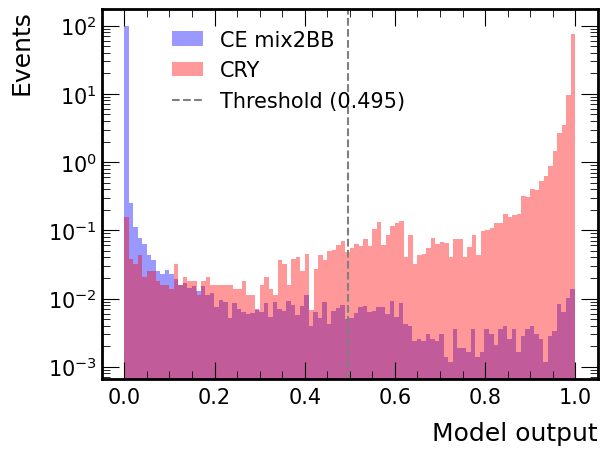

In [40]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
background_scores = test_scores[y_test == 0]  # CE + mix2BB

# Define threshold
threshold = 0.5

# Compute FPR and FNR
false_positives = (background_scores > threshold).sum()   # Background misclassified as signal
true_negatives  = (background_scores <= threshold).sum()

false_negatives = (signal_scores <= threshold).sum()  # Signal misclassified as background
true_positives  = (signal_scores > threshold).sum()

fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)

# Plot score distributions
plt.figure() 

plt.hist(background_scores, bins=100, alpha=0.4, label='CE mix2BB',
         density=True, color='blue')
plt.hist(signal_scores, bins=100, alpha=0.4, label='CRY',
         density=True, color='red')

plt.axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


plt.xlabel('Model output')
plt.ylabel('Events')
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.yscale('log')

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
out_name = img_validation_out_path / "model_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()


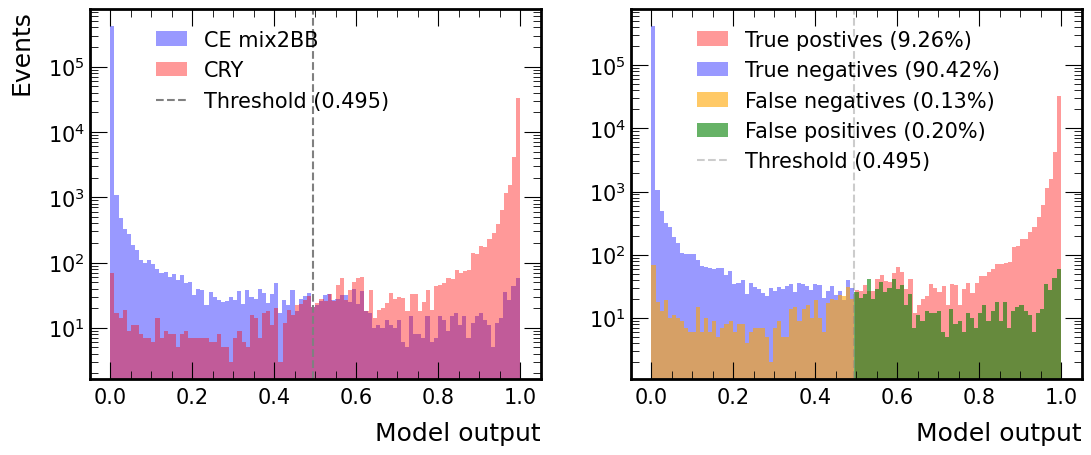

In [41]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # True signal (CRY)
background_scores = test_scores[y_test == 0]  # True background (CE mix)

# Discrimination threshold
threshold = optimal_threshold

# Get false positives and false negatives
false_positives = background_scores[background_scores > threshold]
false_negatives = signal_scores[signal_scores <= threshold]

# Also get true positives and true negatives for comparison
true_positives = signal_scores[signal_scores > threshold]
true_negatives = background_scores[background_scores <= threshold]

# # Boolean masks
# tp_mask = (y_test == 1) & (y_pred_label == 1)
# tn_mask = (y_test == 0) & (y_pred_label == 0)
# fp_mask = (y_test == 0) & (y_pred_label == 1)
# fn_mask = (y_test == 1) & (y_pred_label == 0)


tot = len(test_scores)

# Plot score distributions
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

ax[0].hist(background_scores, bins=100, alpha=0.4, label='CE mix2BB',
         density=False, color='blue')
ax[0].hist(signal_scores, bins=100, alpha=0.4, label='CRY',
         density=False, color='red')
ax[0].axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


ax[0].set_xlabel('Model output')
ax[0].set_ylabel('Events')
ax[0].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[0].set_yscale('log')


ax[1].hist(true_positives, bins=50, alpha=0.4, label=f'True postives ({len(true_positives)*100/tot:.2f}%)', color='red')
ax[1].hist(true_negatives, bins=50, alpha=0.4, label=f'True negatives ({len(true_negatives)*100/tot:.2f}%)', color='blue')
ax[1].hist(false_negatives, bins=50, alpha=0.6, label=f'False negatives ({len(false_negatives)*100/tot:.2f}%)', color='orange')
ax[1].hist(false_positives, bins=50, alpha=0.6, label=f'False positives ({len(false_positives)*100/tot:.2f}%)', color='green')
ax[1].axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, alpha=0.4, label=f"Threshold ({optimal_threshold:.3f})")


ax[1].set_xlabel('Model output')
ax[1].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[1].set_yscale('log')


out_name = img_validation_out_path / "h1o_1x2_model_output.png"
plt.savefig(out_name)


plt.show()


In [42]:
X_test_scaled

array([[-1.37299949, -0.39394641,  0.10008061,  1.37357354],
       [-0.62603143, -0.34052343, -1.38171795, -1.51390202],
       [ 0.80491156, -0.27518203, -0.12720475, -1.0390712 ],
       ...,
       [-0.227847  , -0.39739069,  0.3499201 ,  0.56220528],
       [ 0.39675656, -0.38585535,  1.23682667,  0.64833141],
       [ 0.19914382, -0.35505003, -1.66024426, -1.4820818 ]])

	Wrote ../../../output/images/ml/veto/a/xgboost/validation/features_output.png


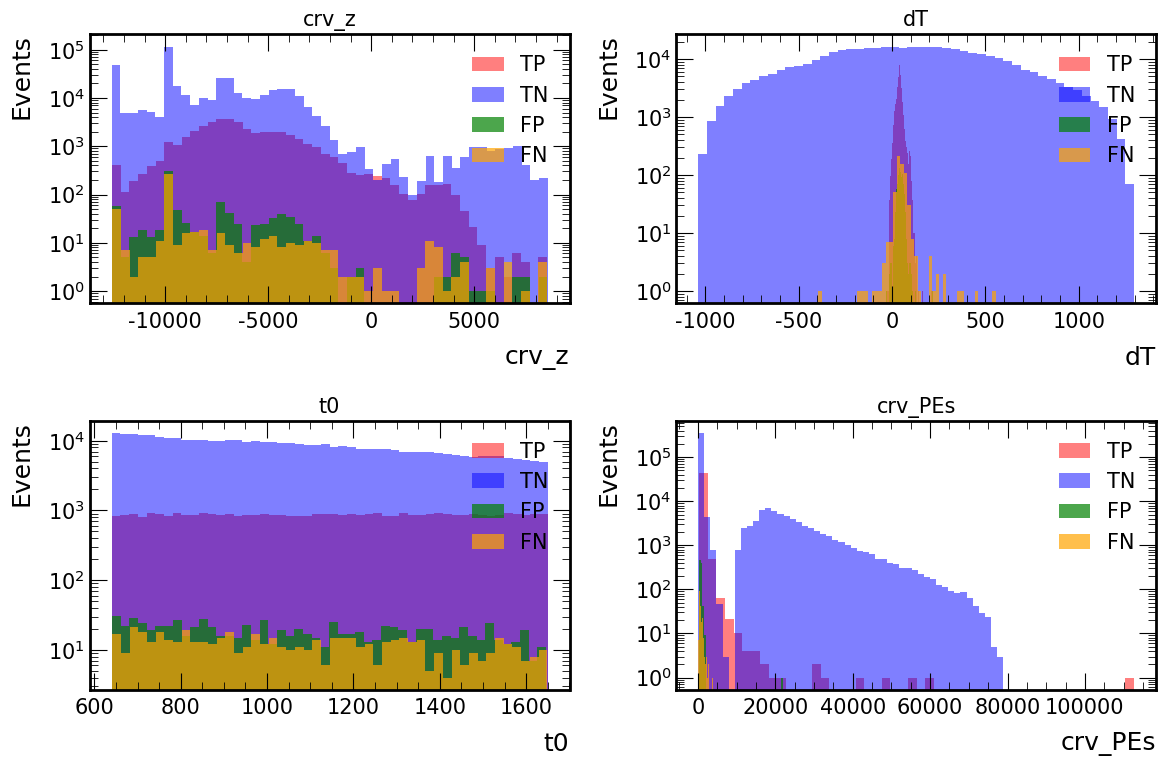

In [43]:
# Create a grid of subplots
n_features = len(feature_names)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

y_pred_label = (test_scores > threshold).astype(int)
# Boolean masks
tp_mask = (y_test == 1) & (y_pred_label == 1)
tn_mask = (y_test == 0) & (y_pred_label == 0)
fp_mask = (y_test == 0) & (y_pred_label == 1)
fn_mask = (y_test == 1) & (y_pred_label == 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    ax.hist(X_test[feature][tp_mask], bins=50, color='red', alpha=0.5, label='TP')
    ax.hist(X_test[feature][tn_mask], bins=50, color='blue', alpha=0.5, label='TN')
    ax.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.7, label='FP')
    ax.hist(X_test[feature][fn_mask], bins=50, color='orange', alpha=0.7, label='FN')
    xlabel = feature
    # if feature in ["d0", "maxr"]: 
    #     xlabel += " [mm]"
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Events')
    ax.set_yscale('log')
    ax.legend() # fontsize=8)


        
    ax.set_title(feature)

# Hide unused subplots
for idx in range(len(feature_names), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

out_name = img_validation_out_path / "features_output.png" 
plt.savefig(out_name)
print(f"\tWrote {out_name}")

plt.show()

In [44]:
# true_positives.keys()

In [45]:
# Signal efficiency (True Positive Rate / Recall)
signal_efficiency = len(true_positives) / len(signal_scores)

# Background rejection rate (True Negative Rate / Specificity)
background_rejection = len(true_negatives) / len(background_scores)

# Background efficiency (what you're rejecting FROM)
background_efficiency = len(false_positives) / len(background_scores)

print(f"Signal Efficiency: {signal_efficiency*100:.2f}%")plt.xlim(0.0, 0.2)
# plt.ylim(0.9999, 1)
print(f"Background Rejection: {background_rejection*100:.2f}%")
print(f"Background Contamination: {background_efficiency*100:.2f}%")

# Check class balance
print(f"\nClass balance:")
print(f"Signal events: {len(signal_scores)} ({len(signal_scores)*100/tot:.2f}%)")
print(f"Background events: {len(background_scores)} ({len(background_scores)*100/tot:.2f}%)")

Signal Efficiency: 98.63%
Background Rejection: 99.78%
Background Contamination: 0.22%

Class balance:
Signal events: 44082 (9.39%)
Background events: 425517 (90.61%)


In [49]:
# Evaluate on training set
y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)

# Evaluate on test set
y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Difference: {train_auc - test_auc:.4f}")

Train AUC: 0.9998
Test AUC:  0.9998
Difference: 0.0000


In [50]:
# Generate predictions on test set
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n" + "="*60)
print("CLASS BALANCE DIAGNOSTIC")
print("="*60)

# 1. Confusion matrix breakdown
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives (correct background):  {tn:,} ({tn/len(y_test)*100:.1f}%)")
print(f"  False Positives (wrong veto):         {fp:,} ({fp/len(y_test)*100:.1f}%)")
print(f"  False Negatives (missed cosmic):      {fn:,} ({fn/len(y_test)*100:.1f}%)")
print(f"  True Positives (correct cosmic):      {tp:,} ({tp/len(y_test)*100:.1f}%)")

# 2. Per-class performance
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"\nPer-Class Metrics:")
print(f"  Signal (Cosmic Ray):")
print(f"    Recall (Sensitivity):    {recall_score(y_test, y_pred):.4f}")
print(f"    Precision (Purity):      {precision_score(y_test, y_pred):.4f}")
print(f"    F1 Score:                {f1_score(y_test, y_pred):.4f}")

print(f"\n  Background (CE):")
print(f"    Recall (Specificity):    {recall_score(y_test, y_pred, pos_label=0):.4f}")
print(f"    Precision:               {precision_score(y_test, y_pred, pos_label=0):.4f}")
print(f"    F1 Score:                {f1_score(y_test, y_pred, pos_label=0):.4f}")

# 3. Score distribution check
median_signal = np.median(y_pred_proba[y_test == 1])
median_bkg = np.median(y_pred_proba[y_test == 0])

print(f"\nScore Distributions:")
print(f"  Signal median score:     {median_signal:.4f}")
print(f"  Background median score: {median_bkg:.4f}")
print(f"  Separation:              {median_signal - median_bkg:.4f}")

# 4. What if we had naive classifier?
naive_acc = np.sum(y_test == 0) / len(y_test)  # Always predict background
print(f"\nNaive Baseline (always predict background):")
print(f"  Accuracy: {naive_acc:.4f}")
print(f"  Your model accuracy: {(tp + tn) / len(y_test):.4f}")
print(f"  Improvement: {((tp + tn) / len(y_test) - naive_acc) / naive_acc * 100:.1f}%")

print("="*60)


CLASS BALANCE DIAGNOSTIC

Confusion Matrix:
  True Negatives (correct background):  424,610 (90.4%)
  False Positives (wrong veto):         907 (0.2%)
  False Negatives (missed cosmic):      619 (0.1%)
  True Positives (correct cosmic):      43,463 (9.3%)

Per-Class Metrics:
  Signal (Cosmic Ray):
    Recall (Sensitivity):    0.9860
    Precision (Purity):      0.9796
    F1 Score:                0.9827

  Background (CE):
    Precision (Purity):      0.9796
    F1 Score:                0.9827

  Background (CE):
    Recall (Specificity):    0.9979
    Precision:               0.9985
    Recall (Specificity):    0.9979
    Precision:               0.9985
    F1 Score:                0.9982

Score Distributions:
  Signal median score:     0.9958
  Background median score: 0.0000
  Separation:              0.9958

Naive Baseline (always predict background):
  Accuracy: 0.9061
  Your model accuracy: 0.9968
  Improvement: 10.0%
    F1 Score:                0.9982

Score Distributions:
  S


✅ Confusion matrix saved to ../../../output/images/ml/veto/a/xgboost/validation/confusion_matrix.png


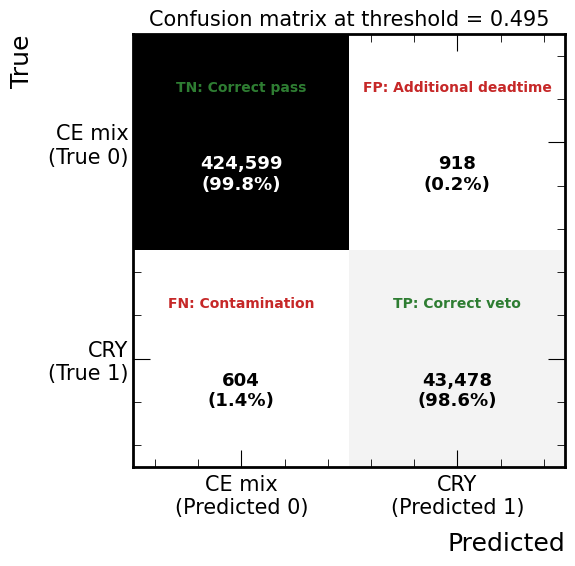


CONFUSION MATRIX BREAKDOWN

Pure CRY sample (label 1): 44,082 events
  ✓ Correctly vetoed (TP):     43,478 (98.63%)
  ✗ Incorrectly passed (FN):   604 (1.37%)

CE mix sample (label 0): 425,517 events
  ✓ Correctly passed (TN):     424,599 (99.78%)
  ✗ Incorrectly vetoed (FP):   918 (0.22%)

Total: 469,599 events
  Correct predictions:         468,077 (99.68%)
  Incorrect predictions:       1,522 (0.32%)


In [ ]:
# Visualize confusion matrix with counts and percentages
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Use optimal threshold
y_pred_optimal = (y_test_pred_proba > optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

# Create custom confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))

# Display the confusion matrix as an image
# Try these colormap alternatives:
# 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys'
# 'YlOrRd', 'YlGnBu', 'RdPu', 'BuPu', 'GnBu'
# 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
im = ax.imshow(cm, interpolation='nearest', cmap='Greys')

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['CE mix\n(Predicted 0)', 'CRY\n(Predicted 1)'])
ax.set_yticklabels(['CE mix\n(True 0)', 'CRY\n(True 1)'])

ax.set_xlabel('Predicted') # , fontsize=12, fontweight='bold')
ax.set_ylabel('True') # , fontsize=12, fontweight='bold')
ax.set_title(f'Confusion matrix at threshold = {optimal_threshold:.3f}') # , fontsize=13, fontweight='bold')

# Calculate percentages (normalised by row - by true label)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add text annotations with both counts and percentages
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = cm_norm[i, j] * 100
        
        # Determine if we need white or black text
        text_color = "white" if cm[i, j] > thresh else "black"
        
        # Add interpretation labels at top
        if i == 0 and j == 0:  # TN
            label = 'TN: Correct pass'
            label_color = '#2E7D32'  # Dark green
        elif i == 0 and j == 1:  # FP
            label = 'FP: Additional deadtime'
            label_color = '#C62828'  # Dark red
        elif i == 1 and j == 0:  # FN
            label = 'FN: Contamination'
            label_color = '#C62828'  # Dark red
        else:  # TP
            label = 'TP: Correct veto'
            label_color = '#2E7D32'  # Gold/yellow for visibility
        
        ax.text(j, i - 0.25, label,
                ha="center", va="center",
                color=label_color, fontsize=10, fontweight='bold')
        
        # Count and percentage below
        ax.text(j, i + 0.15, f'{count:,}\n({percentage:.1f}%)',
                ha="center", va="center",
                color=text_color,
                fontsize=13, fontweight='bold')

plt.tight_layout()

out_name = img_validation_out_path / "confusion_matrix.png"
plt.savefig(out_name) # , dpi=150, bbox_inches='tight')
print(f"\n✅ Confusion matrix saved to {out_name}")

plt.show()

# Print summary
print("\n" + "="*70)
print("CONFUSION MATRIX BREAKDOWN")
print("="*70)
print(f"\nPure CRY sample (label 1): {tp+fn:,} events")
print(f"  ✓ Correctly vetoed (TP):     {tp:,} ({tp/(tp+fn)*100:.2f}%)")
print(f"  ✗ Incorrectly passed (FN):   {fn:,} ({fn/(tp+fn)*100:.2f}%)")

print(f"\nCE mix sample (label 0): {tn+fp:,} events")
print(f"  ✓ Correctly passed (TN):     {tn:,} ({tn/(tn+fp)*100:.2f}%)")
print(f"  ✗ Incorrectly vetoed (FP):   {fp:,} ({fp/(tn+fp)*100:.2f}%)")

print(f"\nTotal: {len(y_test):,} events")
print(f"  Correct predictions:         {tp+tn:,} ({(tp+tn)/len(y_test)*100:.2f}%)")
print(f"  Incorrect predictions:       {fp+fn:,} ({(fp+fn)/len(y_test)*100:.2f}%)")
print("="*70)

## CRV Veto Performance Metrics

**Physics context**: Veto pure cosmic rays while preserving the CE beam sample.

### Key insight:
The CE mix2BB sample contains:
- True CE signal coincidences 
- Pileup-induced cosmic coincidences

**We want to PASS THROUGH the entire CE mix sample** (both CE signal + pileup cosmics) because:
- Vetoing pileup cosmics = unnecessary deadtime inflation
- Pileup cosmics in CE mix don't contaminate the physics signal the same way pure cosmics do

### Training strategy:
- **Label 1 (CRY)**: Pure cosmic sample → VETO these
- **Label 0 (CE mix)**: Mixed CE sample → PASS these (accept both CE + pileup)

### Model performance metrics:
- **Veto Efficiency (ε_veto)**: Fraction of pure cosmic rays correctly vetoed
- **Veto Inefficiency (1 - ε_veto)**: Fraction of pure cosmic rays that slip through (contamination)
- **Deadtime**: Fraction of CE mix events incorrectly vetoed (pure loss)
- **Veto Purity**: Of vetoed events, what fraction are truly from pure cosmic sample

In [65]:
# ==========================================
# CRV VETO PERFORMANCE METRICS
# ==========================================

# LABELS:
#   Label 1 (CRY): Pure cosmic sample - want to VETO
#   Label 0 (CE mix): Mixed CE sample (true CE + pileup cosmics) - want to PASS
#
# PHYSICS GOAL:
#   VETO: Pure cosmic rays (out-of-time backgrounds)
#   PASS: Entire CE mix sample (CE signal + pileup cosmics)
#   
#   Why pass pileup cosmics? Vetoing them inflates deadtime without benefit!

# Get predictions at optimal threshold
y_pred_veto = (y_test_pred_proba > optimal_threshold).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_veto)
tn, fp, fn, tp = cm.ravel()

# INTERPRETATION:
# TP (True Positives)  = Pure CRY correctly vetoed → GOOD ✓
# FN (False Negatives) = Pure CRY missed (passed through) → BAD ✗ (contamination!)
# TN (True Negatives)  = CE mix passed through → GOOD ✓ (desired behavior)
# FP (False Positives) = CE mix incorrectly vetoed → BAD ✗ (deadtime inflation!)

print("\n" + "="*80)
print("CRV VETO PERFORMANCE @ OPTIMAL THRESHOLD")
print("="*80)

# Core veto metrics
veto_efficiency = tp / (tp + fn)  # Fraction of pure cosmics caught
veto_inefficiency = fn / (tp + fn)  # Fraction of pure cosmics that leak through
deadtime_loss = fp / (tn + fp)  # Fraction of CE mix incorrectly vetoed
veto_purity = tp / (tp + fp) if (tp + fp) > 0 else 0  # Of vetoed events, fraction that are pure cosmics

print(f"\n📊 VETO EFFICIENCY (Pure Cosmic Rejection):")
print(f"   Pure CRY correctly vetoed (TP):   {tp:,} / {tp+fn:,}")
print(f"   Veto Efficiency (ε_veto):         {veto_efficiency:.4f} ({veto_efficiency*100:.2f}%)")
print(f"   Veto Inefficiency (1-ε_veto):     {veto_inefficiency:.6f} ({veto_inefficiency*100:.4f}%)")
print(f"   → Cosmic contamination = {veto_inefficiency:.2e}")
print(f"\n   ⚠️  These pure cosmics contaminate your sample!")

print(f"\n⏱️  DEADTIME (CE Mix Incorrectly Vetoed):")
print(f"   CE mix correctly passed (TN):     {tn:,} / {tn+fp:,}")
print(f"   CE mix incorrectly vetoed (FP):   {fp:,} / {tn+fp:,}")
print(f"   Deadtime fraction:                {deadtime_loss:.4f} ({deadtime_loss*100:.2f}%)")
print(f"\n   ⚠️  Vetoing CE mix = pure deadtime loss!")
print(f"       (includes both true CE + pileup cosmics - both undesirable to veto)")

print(f"\n✅ VETO PURITY:")
print(f"   Total events vetoed:              {tp+fp:,}")
print(f"   - Pure CRY (good veto):           {tp:,} ({tp/(tp+fp)*100:.1f}%)")
print(f"   - CE mix (bad veto/deadtime):     {fp:,} ({fp/(tp+fp)*100:.1f}%)")
print(f"   Veto purity:                      {veto_purity:.4f} ({veto_purity*100:.2f}%)")

print(f"\n⚡ SUMMARY:")
print(f"   Total test events:                {len(y_test):,}")
print(f"   Correctly classified:             {tp+tn:,} ({(tp+tn)/len(y_test)*100:.1f}%)")
print(f"   Misclassified:                    {fp+fn:,} ({(fp+fn)/len(y_test)*100:.1f}%)")
print(f"     - Contamination (FN):           {fn:,} (pure cosmics leaked)")
print(f"     - Deadtime (FP):                {fp:,} (CE mix wrongly vetoed)")

print("="*70)


CRV VETO PERFORMANCE @ OPTIMAL THRESHOLD

📊 VETO EFFICIENCY (Pure Cosmic Rejection):
   Pure CRY correctly vetoed (TP):   43,478 / 44,082
   Veto Efficiency (ε_veto):         0.9863 (98.63%)
   Veto Inefficiency (1-ε_veto):     0.013702 (1.3702%)
   → Cosmic contamination = 1.37e-02

   ⚠️  These pure cosmics contaminate your sample!

⏱️  DEADTIME (CE Mix Incorrectly Vetoed):
   CE mix correctly passed (TN):     424,599 / 425,517
   CE mix incorrectly vetoed (FP):   918 / 425,517
   Deadtime fraction:                0.0022 (0.22%)

   ⚠️  Vetoing CE mix = pure deadtime loss!
       (includes both true CE + pileup cosmics - both undesirable to veto)

✅ VETO PURITY:
   Total events vetoed:              44,396
   - Pure CRY (good veto):           43,478 (97.9%)
   - CE mix (bad veto/deadtime):     918 (2.1%)
   Veto purity:                      0.9793 (97.93%)

⚡ SUMMARY:
   Total test events:                469,599
   Correctly classified:             468,077 (99.7%)
   Misclassified:  

In [69]:
# ==========================================
# SAVE CRV VETO METRICS TO CSV
# ==========================================

# Create results directory
results_out_path = Path(f"../../../output/ml/veto/xgboost/{run}/results")
results_out_path.mkdir(parents=True, exist_ok=True)

# Calculate all metrics
metrics_data = {
    'Metric': [
        'Veto efficiency (Pure CRY)',
        'Veto inefficiency (Pure CRY)', 
        'CE mix veto rate (Additional deadtime)',
        'CE mix pass rate',
        'Veto purity',
        'Overall accuracy'
    ],
    'Formula': [
        'TP / (TP + FN)',
        'FN / (TP + FN)',
        'FP / (TN + FP)',
        'TN / (TN + FP)',
        'TP / (TP + FP)',
        '(TP + TN) / (TP + TN + FP + FN)'
    ],
    'Value': [
        veto_efficiency,
        veto_inefficiency,
        deadtime_loss,
        1 - deadtime_loss,  # CE Mix Pass Rate = 1 - deadtime
        veto_purity,
        (tp + tn) / (tp + tn + fp + fn)
    ],
    'Description': [
        'Fraction of pure cosmic rays successfully vetoed',
        'Fraction of pure cosmic rays that slip through (contamination)',
        'Fraction of CE mix events vetoed (deadtime)',
        'Fraction of CE mix events passed through (preserved beam data)',
        'Of all vetoed events, fraction that are pure cosmics',
        'Overall correct classification rate'
    ]
}

# Add confusion matrix counts
confusion_data = {
    'Metric': ['True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)'],
    'Count': [int(tp), int(tn), int(fp), int(fn)],
    'Description': [
        'Pure CRY correctly vetoed',
        'CE mix correctly passed',
        'CE mix incorrectly vetoed (additional deadtime)',
        'Pure CRY incorrectly passed (contamination)'
    ]
}

# Create DataFrames
metrics_df = pd.DataFrame(metrics_data)
confusion_df = pd.DataFrame(confusion_data)

# Save to CSV files
metrics_file_path = results_out_path / "crv_metrics_results.csv"
confusion_file_path = results_out_path / "confusion_matrix_counts.csv"

metrics_df.to_csv(metrics_file_path, index=False, float_format='%.6f')
confusion_df.to_csv(confusion_file_path, index=False)

print(f"\n✅ CRV metrics saved to:")
print(f"   {metrics_file_path}")
print(f"   {confusion_file_path}")

# Display the results
print("\n" + "="*80)
print("CRV VETO METRICS SUMMARY")
print("="*80)
display(metrics_df)

print("\n" + "="*80)
print("CONFUSION MATRIX COUNTS")
print("="*80)
display(confusion_df)



✅ CRV metrics saved to:
   ../../../output/ml/veto/xgboost/a/results/crv_metrics_results.csv
   ../../../output/ml/veto/xgboost/a/results/confusion_matrix_counts.csv

CRV VETO METRICS SUMMARY


,Metric,Formula,Value,Description
0,Veto efficiency (Pure CRY),TP / (TP + FN),0.986298,Fraction of pure cosmic rays successfully vetoed
1,Veto inefficiency (Pure CRY),FN / (TP + FN),0.013702,Fraction of pure cosmic rays that slip through...
2,CE mix veto rate (Additional deadtime),FP / (TN + FP),0.002157,Fraction of CE mix events vetoed (deadtime)
3,CE mix pass rate,TN / (TN + FP),0.997843,Fraction of CE mix events passed through (pres...
4,Veto purity,TP / (TP + FP),0.979322,"Of all vetoed events, fraction that are pure c..."
5,Overall accuracy,(TP + TN) / (TP + TN + FP + FN),0.996759,Overall correct classification rate



CONFUSION MATRIX COUNTS


,Metric,Count,Description
0,True Positives (TP),43478,Pure CRY correctly vetoed
1,True Negatives (TN),424599,CE mix correctly passed
2,False Positives (FP),918,CE mix incorrectly vetoed (additional deadtime)
3,False Negatives (FN),604,Pure CRY incorrectly passed (contamination)


In [ ]:
# # Example traditional cuts (adjust these to your physics case)
# def apply_kin_cuts(X):
#     """Apply kinematic parameter cuts for signal selection"""
#     cuts = (
#         (X['d0'] < 100) &           
#         (X['maxr'] < 680) &         
#         (X['tanDip'] > 0.5) &  
#         (X['tanDip'] < 1.0) # &        
#         # (X['t0err'] < 0.9)   
#     )
#     return cuts

# # Apply cuts to test set

# cut_based_pred = apply_kin_cuts(X_test).astype(int)

# print(X_test)
# print(len(cut_based_pred[cut_based_pred==1])/len(cut_based_pred))
# # print(len(X_test), len(cut_based_pred[2]))
# # cut_based_pred = apply_kin_cuts(X_test).astype(int)

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# # ML predictions
# y_pred_ml = (test_scores > optimal_threshold).astype(int)

# # Calculate confusion matrices
# cm_ml = confusion_matrix(y_test, y_pred_ml)
# cm_cuts = confusion_matrix(y_test, cut_based_pred)

# # Extract TP, TN, FP, FN for both methods
# def get_metrics(cm):
#     tn, fp, fn, tp = cm.ravel()
    
#     signal_efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
#     background_rejection = tn / (tn + fp) if (tn + fp) > 0 else 0
#     purity = tp / (tp + fp) if (tp + fp) > 0 else 0
    
#     # Calculate significance
#     S = tp
#     B = fp
#     significance = S / np.sqrt(S + B) if (S + B) > 0 else 0
    
#     return {
#         'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
#         'Signal efficiency': signal_efficiency,
#         'Background rejection': background_rejection,
#         'Purity': purity,
#         'Significance': significance
#     }

# metrics_ml = get_metrics(cm_ml)
# metrics_cuts = get_metrics(cm_cuts)

# # # Print comparison
# # print("=" * 60)
# # print("Performance comparison: ML vs kinematic cuts")
# # print("=" * 60)
# # print(f"{'Metric':<25} {'ML':<15} {'Cuts':<15} {'Improvement':<15}")
# # print("-" * 60)

# # for key in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']:
# #     ml_val = metrics_ml[key]
# #     cut_val = metrics_cuts[key]
# #     improvement = ((ml_val - cut_val) / cut_val * 100) if cut_val > 0 else 0
    
# #     print(f"{key:<25} {ml_val:.4f}        {cut_val:.4f}        {improvement:+.1f}%")

# # print("-" * 60)
# # print(f"{'True positives':<25} {metrics_ml['TP']:<15} {metrics_cuts['TP']:<15}")
# # print(f"{'False positives':<25} {metrics_ml['FP']:<15} {metrics_cuts['FP']:<15}")
# # print(f"{'False negatives':<25} {metrics_ml['FN']:<15} {metrics_cuts['FN']:<15}")
# # print(f"{'True negatives':<25} {metrics_ml['TN']:<15} {metrics_cuts['TN']:<15}")


# # Metrics DataFrame (with percentages/rates)
# metrics_df = pd.DataFrame({
#     'Metric': ['Signal efficiency', 'Background rejection', 'Purity', 'Significance'],
#     'ML': [metrics_ml[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']],
#     'Cuts': [metrics_cuts[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']]
# })
# metrics_df['Improvement [%]'] = ((metrics_df['ML'] - metrics_df['Cuts']) / metrics_df['Cuts'] * 100)

# # Counts DataFrame
# # counts_df = pd.DataFrame({
# #     'Category': ['True positives', 'False positives', 'False negatives', 'True negatives'],
# #     'ML': [metrics_ml['TP'], metrics_ml['FP'], metrics_ml['FN'], metrics_ml['TN']],
# #     'Cuts': [metrics_cuts['TP'], metrics_cuts['FP'], metrics_cuts['FN'], metrics_cuts['TN']]
# # })

# counts_df = pd.DataFrame({
#     'Category': ['True positives', 'True negatives', 'False positives', 'False negatives'],
#     'ML': [metrics_ml['TP'], metrics_ml['TN'], metrics_ml['FP'], metrics_ml['FN']],
#     'Cuts': [metrics_cuts['TP'], metrics_cuts['TN'], metrics_cuts['FP'], metrics_cuts['FN']]
# })

# counts_df['Difference'] = counts_df['ML'] - counts_df['Cuts']

# print("\n=== Performance metrics ===")
# display(metrics_df)
# print("\n=== Event counts ===")
# display(counts_df)



In [ ]:
# # Cosmic Ray Rejection Performance Table
# cosmic_rejection_df = pd.DataFrame({
#     'Metric': [
#         'Cosmic rays rejected (TN)',
#         'Cosmic rays accepted (FP)', 
#         'Background rejection rate',
#         'Cosmic contamination rate',
#         'Sample purity (beam)',
#         'Beam events retained (TP)',
#         'Beam signal efficiency',
#         'Overall significance (S/√(S+B))'
#     ],
#     'ML': [
#         metrics_ml['TN'],
#         metrics_ml['FP'],
#         f"{metrics_ml['Background rejection']*100:.2f}%",
#         f"{(metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']))*100:.2f}%",
#         f"{metrics_ml['Purity']*100:.2f}%",
#         metrics_ml['TP'],
#         f"{metrics_ml['Signal efficiency']*100:.2f}%",
#         f"{metrics_ml['Significance']:.1f}"
#     ],
#     'Cuts': [
#         metrics_cuts['TN'],
#         metrics_cuts['FP'],
#         f"{metrics_cuts['Background rejection']*100:.2f}%",
#         f"{(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100:.2f}%",
#         f"{metrics_cuts['Purity']*100:.2f}%",
#         metrics_cuts['TP'],
#         f"{metrics_cuts['Signal efficiency']*100:.2f}%",
#         f"{metrics_cuts['Significance']:.1f}"
#     ],
#     'Improvement': [
#         f"+{metrics_ml['TN'] - metrics_cuts['TN']}",
#         f"{metrics_ml['FP'] - metrics_cuts['FP']}",
#         f"+{((metrics_ml['Background rejection'] - metrics_cuts['Background rejection'])/metrics_cuts['Background rejection']*100):.1f}%",
#         f"{((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%",
#         f"+{(metrics_ml['Purity'] - metrics_cuts['Purity'])*100:.2f}%",
#         f"+{metrics_ml['TP'] - metrics_cuts['TP']}",
#         f"+{((metrics_ml['Signal efficiency'] - metrics_cuts['Signal efficiency'])/metrics_cuts['Signal efficiency']*100):.1f}%",
#         f"+{((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}%"
#     ]
# })

# print("\n" + "="*80)
# print("COSMIC RAY REJECTION PERFORMANCE: ML vs Kinematic Cuts")
# print("="*80)
# display(cosmic_rejection_df)

# # Add summary statistics
# total_cosmics = metrics_ml['TN'] + metrics_ml['FP']
# total_beam = metrics_ml['TP'] + metrics_ml['FN']

# print("\n" + "="*80)
# print("KEY FINDINGS")
# print("="*80)
# print(f"• ML rejects {metrics_ml['TN'] - metrics_cuts['TN']} additional cosmic ray backgrounds")
# print(f"• ML reduces cosmic contamination by {abs((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%")
# print(f"• ML retains {metrics_ml['TP'] - metrics_cuts['TP']} additional beam events")
# print(f"• Net result: {((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}% improvement in significance")
# print(f"\nDataset composition: {total_beam:,} beam events, {total_cosmics:,} cosmic events")

In [ ]:
# # # Selection rate on PURE signal dataset
# # signal_selection_rate = metrics_cuts['TP'] / (metrics_cuts['TP'] + metrics_cuts['FN'])
# # print(f"Signal selection rate (cuts): {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")

# # # This is actually the same as signal efficiency!
# # # It's asking: "Of all signal events, what fraction passes cuts?"

# # # For comparison - ML signal selection rate
# # signal_selection_rate_ml = metrics_ml['TP'] / (metrics_ml['TP'] + metrics_ml['FN'])
# # print(f"Signal selection rate (ML): {signal_selection_rate_ml:.4f} ({signal_selection_rate_ml*100:.2f}%)")

# # # Background selection rate (what fraction of background passes - you want this LOW)
# # background_selection_rate_cuts = metrics_cuts['FP'] / (metrics_cuts['FP'] + metrics_cuts['TN'])
# # background_selection_rate_ml = metrics_ml['FP'] / (metrics_ml['FP'] + metrics_ml['TN'])

# # print(f"\nBackground selection rate (cuts): {background_selection_rate_cuts:.4f} ({background_selection_rate_cuts*100:.2f}%)")
# # print(f"Background selection rate (ML): {background_selection_rate_ml:.4f} ({background_selection_rate_ml*100:.2f}%)")

# # Apply cuts to the pure signal dataset
# cut_based_sig = apply_kin_cuts(df_sig.drop('label', axis=1))

# # Calculate selection rate on pure signal sample
# signal_selection_rate = cut_based_sig.sum() / len(df_sig)
# print(f"Selection rate on pure signal dataset: {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")
# print(f"Events passing cuts: {cut_based_sig.sum()} / {len(df_sig)}")

# # Compare to what you got on test set
# print(f"\nFor comparison:")
# print(f"Signal efficiency on test set: {metrics_cuts['Signal efficiency']:.4f} ({metrics_cuts['Signal efficiency']*100:.2f}%)")

# # Apply cuts to pure background dataset
# cut_based_bkg = apply_kin_cuts(df_bkg.drop('label', axis=1))

# background_selection_rate = cut_based_bkg.sum() / len(df_bkg)
# print(f"Selection rate on pure background dataset: {background_selection_rate:.4f} ({background_selection_rate*100:.2f}%)")
# print(f"\nFor comparison:")
# print(f"Background contamination on test set: {1 - metrics_cuts['Background rejection']:.4f} ({(1 - metrics_cuts['Background rejection'])*100:.2f}%)")

In [ ]:
# from sklearn.metrics import roc_curve, auc

# # ML ROC curve
# fpr_ml, tpr_ml, _ = roc_curve(y_test, test_scores)
# roc_auc_ml = auc(fpr_ml, tpr_ml)

# # For cut-based, create a simple ROC point
# tpr_cuts = metrics_cuts['Signal efficiency']
# fpr_cuts = 1 - metrics_cuts['Background rejection']

# plt.figure(figsize=(8, 6))
# plt.plot(fpr_ml, tpr_ml, label=f'ML (AUC = {roc_auc_ml:.3f})', linewidth=2)
# plt.scatter(fpr_cuts, tpr_cuts, color='blue', s=100, zorder=5, 
#            label=f'Kinematic cuts', marker='o')
# plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlabel(r'False positive rate (1 $-$ background rejection)')
# plt.ylabel('True positive rate (signal efficiency)')
# plt.title('ROC curve: ML vs cuts')
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)
# plt.tight_layout()

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
# out_name = f"{out_path}/roc_curve_kin_cuts.png"
# plt.savefig(out_name)


# plt.show()

In [ ]:
# # Scan thresholds for both methods
# thresholds_ml = np.linspace(0, 1, 100)
# significance_ml = []

# for thr in thresholds_ml:
#     y_pred = (test_scores > thr).astype(int)
#     S = ((y_test == 1) & (y_pred == 1)).sum()
#     B = ((y_test == 0) & (y_pred == 1)).sum()
#     sig = S / np.sqrt(S + B) if (S + B) > 0 else 0
#     significance_ml.append(sig)

# # Get cut-based significance (single point)
# S_cuts = metrics_cuts['TP']
# B_cuts = metrics_cuts['FP']
# sig_cuts = metrics_cuts['Significance']

# plt.figure() # figsize=(10, 6))
# plt.plot(thresholds_ml, significance_ml, label='ML', linewidth=2)
# plt.axhline(sig_cuts, color='grey', linestyle='--', linewidth=2, 
#            label=f'Cuts (Sig = {sig_cuts:.2f})')
# plt.axvline(optimal_threshold, color='grey', linewidth=2, linestyle=':',
#            label=f'Optimal threshold ({optimal_threshold:.3f})')
# plt.xlabel('Threshold')
# plt.ylabel(r'Significance ($S/\sqrt{S+B}$)')
# plt.title('Signal significance: ML vs cuts')
# plt.legend(loc="lower left")
# plt.grid(alpha=0.3)
# plt.tight_layout()

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
# out_name = f"{out_path}/sig_sif_mix_kin_cuts.png"
# plt.savefig(out_name)

# plt.show()

# print(f"\nMaximum ML Significance: {max(significance_ml):.2f}")
# print(f"Cut-based Significance: {sig_cuts:.2f}")
# print(f"Improvement: {(max(significance_ml) - sig_cuts)/sig_cuts*100:.1f}%")

In [ ]:
# # Show which events pass ML but fail cuts, and vice versa
# ml_only = (y_pred_ml == 1) & (cut_based_pred == 0)
# cuts_only = (y_pred_ml == 0) & (cut_based_pred == 1)
# both = (y_pred_ml == 1) & (cut_based_pred == 1)

# print(f"\nEvents passing ML only: {ml_only.sum()}")
# print(f"Events passing Cuts only: {cuts_only.sum()}")
# print(f"Events passing both: {both.sum()}")

In [ ]:
# feature = 'd0'

# plt.figure(figsize=(8,6))
# plt.hist(X_test[feature][tp_mask], bins=50, color='royalblue', alpha=0.5, label='True Positives')
# plt.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.5, label='False Positives')
# plt.hist(X_test[feature][fn_mask], bins=50, color='khaki', alpha=0.7, label='False Negatives')
# plt.hist(X_test[feature][tn_mask], bins=50, color='red', alpha=0.5, label='True Negatives')
# plt.xlabel(feature)
# plt.ylabel('# of events')
# plt.yscale('log')
# plt.legend()
# plt.title(f'{feature} distribution by classification result')
# plt.show()


In [ ]:
# # import xgboost as xgb
# # import matplotlib.pyplot as plt

# # xgb.plot_tree(model, num_trees=0, rankdir="LR")  # "LR" = left-to-right
# # plt.show()

# from xgboost import to_graphviz

# # Generate a Graphviz object
# dot = to_graphviz(model, num_trees=0, rankdir="LR")

# # Save as a crisp vector PDF
# dot.render("xgb_tree", format="pdf")

# # or as a high-quality PNG (set dpi)
# dot.render("xgb_tree", format="png")



In [ ]:
# xgb.plot_importance(model, importance_type='gain')
# plt.tight_layout()
# plt.show()